# Imports

In [1]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.5/100.5 kB 3.1 MB/s eta 0:00:00


In [19]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Functions

In [50]:
def plotar_mapa_cafeterias(grafo, pois, margem=0.01):
    """
    Plota o grafo com os cafés extraídos do OSM, ajustando a área de visualização automaticamente.
    """

    print("🔍 Preparando dados para o plot...")

    # Substituir geometrias que não são Point por seus centroides
    pois['geometry'] = pois['geometry'].apply(
        lambda g: g.centroid if g.geom_type != 'Point' else g
    )

    # Filtrar apenas os cafés com geometria válida
    cafes = pois[pois.geometry.type == 'Point']

    if cafes.empty:
        print("⚠️ Nenhuma cafeteria com geometria válida foi encontrada para plotar.")
        return

    # Coordenadas dos cafés
    lats = cafes.geometry.y
    lons = cafes.geometry.x

    # Calcular limites do mapa
    min_lat, max_lat = lats.min() - margem, lats.max() + margem
    min_lon, max_lon = lons.min() - margem, lons.max() + margem

    print(f"🗺️ Plotando mapa de Natal com {len(cafes)} cafeterias...")
    fig, ax = plt.subplots(figsize=(16, 12), dpi=300)

    # Plotar o grafo
    ox.plot_graph(
        grafo,
        ax=ax,
        node_size=0,
        edge_color='gray',
        edge_linewidth=0.5,
        show=False,
        close=False
    )

    # Plotar os cafés
    cafes.plot(
        ax=ax,
        color='blue',
        markersize=40,
        marker='o',
        alpha=0.8,
        label=f'Cafeterias ({len(cafes)})'
    )

    # Ajustes visuais
    ax.set_xlim(min_lon, max_lon)
    ax.set_ylim(min_lat, max_lat)
    ax.set_title("Mapa cafeterias de Natal - RN", fontsize=16)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [48]:
def plotar_mst_cafeterias(grafo, pois, mst_edges, cafe_nodes, margem=0.01):
    """
    Plota o grafo da cidade com as cafeterias e destaca as rotas da MST em vermelho.

    - grafo: grafo viário (networkx.MultiDiGraph)
    - pois: GeoDataFrame com cafeterias
    - mst_edges: lista de arestas da MST, formato [(u,v,d), ...]
    - cafe_nodes: lista dos nós do grafo mais próximos das cafeterias
    """

    # Preparar cafés (pontos ou centroides)
    pois['geometry'] = pois['geometry'].apply(
        lambda g: g.centroid if g.geom_type != 'Point' else g
    )
    cafes = pois[pois.geometry.type == 'Point']

    if cafes.empty:
        print("⚠️ Nenhuma cafeteria válida para plotar.")
        return

    lats = cafes.geometry.y
    lons = cafes.geometry.x

    min_lat, max_lat = lats.min() - margem, lats.max() + margem
    min_lon, max_lon = lons.min() - margem, lons.max() + margem

    print(f"🗺️ Plotando mapa com {len(cafes)} cafeterias e MST...")

    fig, ax = plt.subplots(figsize=(16, 12), dpi=300)

    # Plotar grafo base
    ox.plot_graph(
        grafo,
        ax=ax,
        node_size=0,
        edge_color='gray',
        edge_linewidth=0.5,
        show=False,
        close=False
    )

    # Plotar MST em vermelho
    for (u, v, d) in mst_edges:
        route = nx.shortest_path(grafo, u, v, weight='length')
        x = [grafo.nodes[n]['x'] for n in route]
        y = [grafo.nodes[n]['y'] for n in route]
        ax.plot(x, y, color='red', linewidth=2, zorder=4)

    # Plotar cafeterias em azul
    poi_x = [grafo.nodes[n]['x'] for n in cafe_nodes]
    poi_y = [grafo.nodes[n]['y'] for n in cafe_nodes]
    ax.scatter(poi_x, poi_y, c='blue', s=80, zorder=5, edgecolor='black', label='Cafeterias')

    # Ajustes visuais
    ax.set_xlim(min_lon, max_lon)
    ax.set_ylim(min_lat, max_lat)
    ax.set_title("Mapa cafeterias de Natal - RN com MST", fontsize=16)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend(loc='upper left')

    plt.tight_layout()
    plt.show()


In [43]:
def to_undirected_multigraph(G):
    """
    Converte um MultiDiGraph direcionado em um MultiGraph não-direcionado,
    preservando atributos dos nós e arestas.
    """
    H = nx.MultiGraph()
    # Copiar nós e seus atributos
    for n, data in G.nodes(data=True):
        H.add_node(n, **data)

    # Copiar arestas e seus atributos, sem direcionamento
    for u, v, data in G.edges(data=True):
        # Em um MultiGraph, se já existir uma aresta u-v, esta será adicionada como mais uma aresta paralela
        H.add_edge(u, v, **data)

    # Copiar atributos do grafo
    H.graph.update(G.graph)
    return H

# Análise cafeterias

In [38]:
# Obter o grafo de Natal
print("Carregando grafo de Natal...")
G = ox.graph_from_place("Natal, Rio Grande do Norte, Brazil", network_type='drive')

# Obter cafés
print("Carregando cafés...")
#tags = {'highway': 'bus_stop'}

tags = {'amenity': 'cafe'}
pois = ox.features.features_from_place("Natal, Rio Grande do Norte, Brazil", tags=tags)

# Verificar se foram encontrados pontos
print(f"Encontrados {len(pois)} cafés")

Carregando grafo de Natal...
Carregando cafés...
Encontrados 20 cafés


In [31]:
pois

geometry  \
element id                                                               
node    501253470                           POINT (-35.18577 -5.86625)   
        503490478                            POINT (-35.2468 -5.75878)   
        570460605                           POINT (-35.20711 -5.81163)   
        1057159264                          POINT (-35.20523 -5.85119)   
        1057826742                          POINT (-35.21119 -5.84128)   
        1057826867                           POINT (-35.2111 -5.84125)   
        1781888182                           POINT (-35.2103 -5.84538)   
        4848547621                           POINT (-35.2142 -5.85945)   
        8284481786                          POINT (-35.19613 -5.78574)   
        9017323603                          POINT (-35.19868 -5.79135)   
        9972320734                          POINT (-35.19996 -5.85541)   
        10061906560                         POINT (-35.20961 -5.83538)   
        10061912300                         POINT (-35.20078 -5.79298)   
        10793781382                         POINT (-35.18558 -5.86607)   
        10793781386                         POINT (-35.18533 -5.86604)   
        10892482482                         POINT (-35.19775 -5.78891)   
        11808227084                         POINT (-35.17782 -5.87162)   
        12398828096                           POINT (-35.2067 -5.8472)   
way     718196564    POLYGON ((-35.20064 -5.7894, -35.20067 -5.7894...   
        1034658956   POLYGON ((-35.20756 -5.78792, -35.20754 -5.787...   

                    amenity                    name wheelchair  \
element id                                                       
node    501253470      cafe      Café da Potylivros        yes   
        503490478      cafe                     NaN        NaN   
        570460605      cafe   Casa do Pão de Queijo        NaN   
        1057159264     cafe           Pé de Moleque        NaN   
        1057826742     cafe           Café da Praça        NaN   
        1057826867     cafe           Café do Ponto        NaN   
        1781888182     cafe   Casa do Pão de Queijo        NaN   
        4848547621     cafe        Tropical Lanches        NaN   
        8284481786     cafe          Florêncio Café        NaN   
        9017323603     cafe              Prima Café        NaN   
        9972320734     cafe      Cafeteria Caffeina        NaN   
        10061906560    cafe  Mahalila Café & Livros        NaN   
        10061912300    cafe              Chapelatto        NaN   
        10793781382    cafe                   nobel        NaN   
        10793781386    cafe                   mezzo        NaN   
        10892482482    cafe   Colonial Café & Sabor        NaN   
        11808227084    cafe              Kiosque 25        NaN   
        12398828096    cafe   Jolie Café Patisserie        NaN   
way     718196564      cafe                São Braz    limited   
        1034658956     cafe            Café Cidadão        NaN   

                                     brand brand:wikidata  \
element id                                                  
node    501253470                      NaN            NaN   
        503490478                      NaN            NaN   
        570460605    Casa do Pão de Queijo       Q9698946   
        1057159264                     NaN            NaN   
        1057826742                     NaN            NaN   
        1057826867                     NaN            NaN   
        1781888182   Casa do Pão de Queijo       Q9698946   
        4848547621                     NaN            NaN   
        8284481786                     NaN            NaN   
        9017323603                     NaN            NaN   
        9972320734                     NaN            NaN   
        10061906560                    NaN            NaN   
        10061912300                    NaN            NaN   
        10793781382                    NaN            NaN   
    

🔍 Preparando dados para o plot...
🗺️ Plotando mapa de Natal com 20 cafeterias...


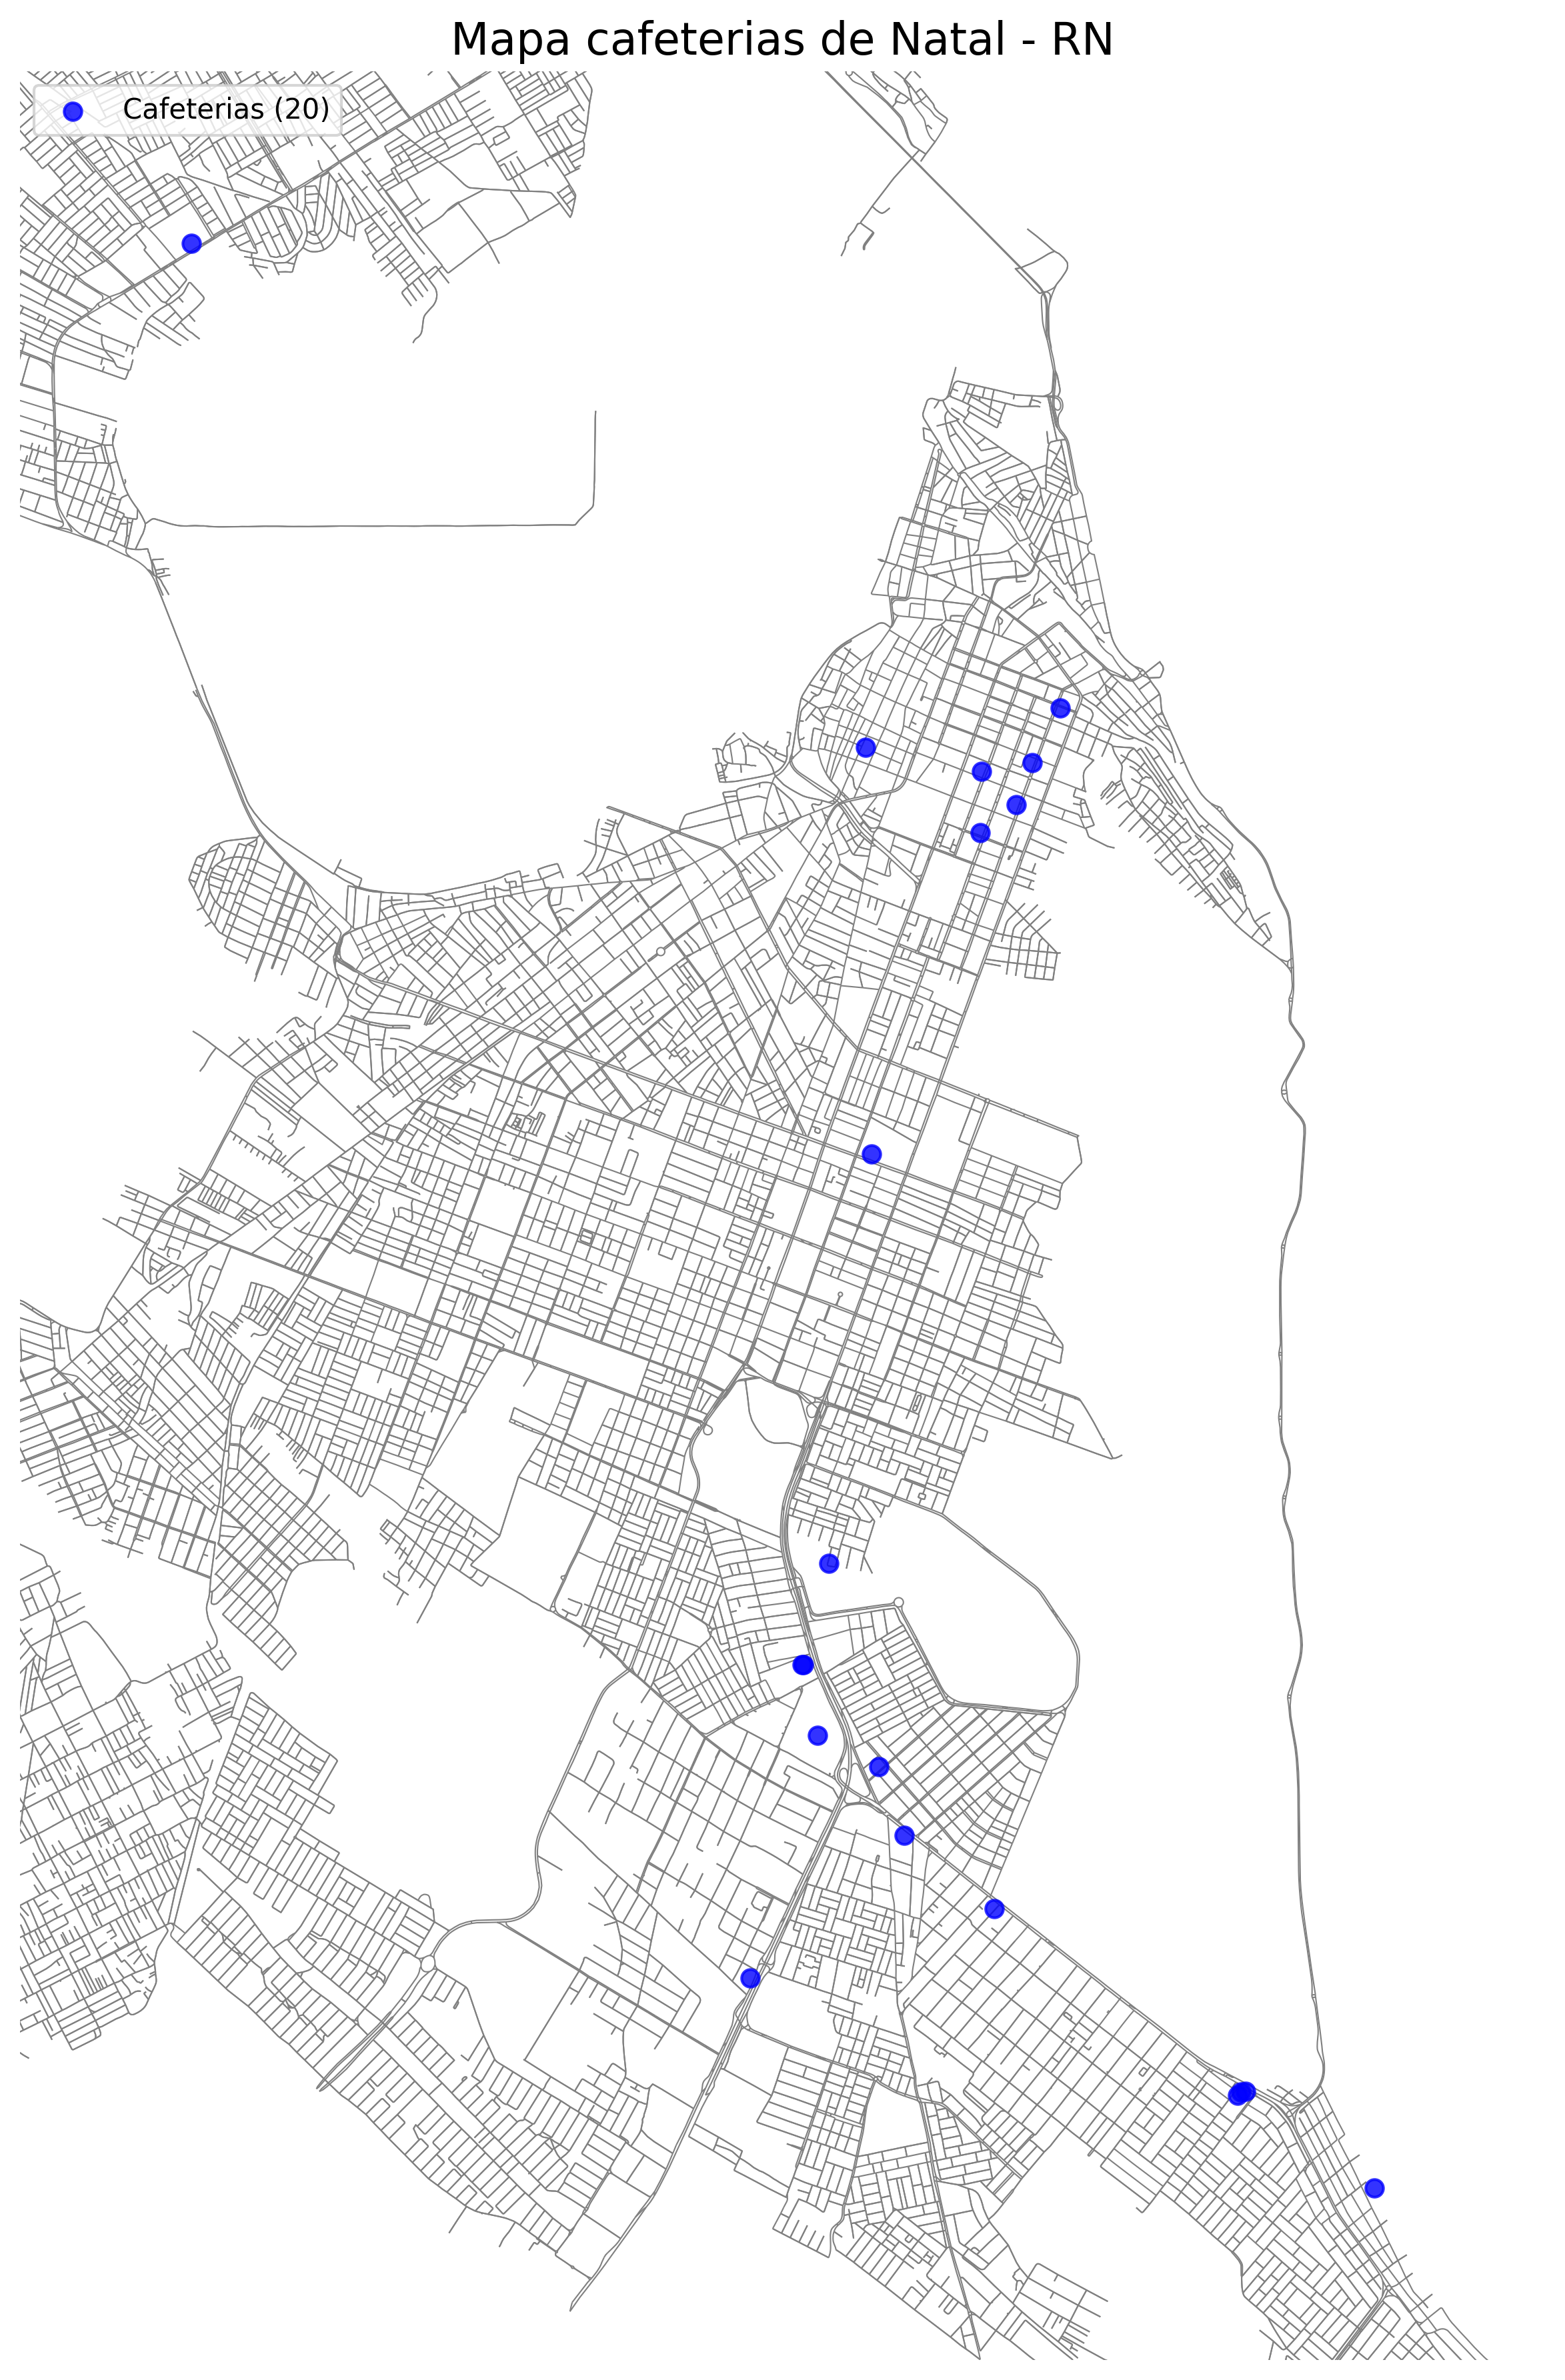

In [51]:
# Plotar o grafo com as cafeterias em destaque
plotar_mapa_cafeterias(G, pois)

In [52]:
# Extrair pontos representativos (usando centroides quando necessário)
cafe_points = []
place = "Natal, Rio Grande do Norte, Brazil"

for idx, row in pois.iterrows():
    geom = row.geometry
    if geom.geom_type == 'Point':
        cafe_points.append((geom.y, geom.x))
    else:
        cafe_points.append((geom.centroid.y, geom.centroid.x))

# Se ainda assim não encontrar nada, lançar erro
if not cafe_points:
    raise ValueError("Nenhum ponto de cafeteria ou padaria encontrado no OpenStreetMap.")

In [53]:
G_undirected = to_undirected_multigraph(G)

# Separar as coordenadas dos pontos
latitudes = [cp[0] for cp in cafe_points]
longitudes = [cp[1] for cp in cafe_points]

# Obter os nós mais próximos no grafo
cafe_nodes = ox.distance.nearest_nodes(G_undirected, X=longitudes, Y=latitudes)
cafe_nodes = list(set(cafe_nodes))  # Remover duplicatas, se houver

# Verificação mínima para construir MST
if len(cafe_nodes) < 2:
    raise ValueError("POIs insuficientes para criar uma MST (menos de 2 pontos).")

In [54]:
G_interest = nx.Graph()

for i in range(len(cafe_nodes)):
    for j in range(i + 1, len(cafe_nodes)):
        # Encontrar caminho mais curto entre os nós i e j com base no comprimento da rota
        route = nx.shortest_path(G_undirected, cafe_nodes[i], cafe_nodes[j], weight='length')

        # Calcular o comprimento total da rota
        route_length = 0
        for k in range(len(route) - 1):
            # Como G pode ser MultiGraph, acessar a aresta com índice [0]
            route_length += G_undirected[route[k]][route[k + 1]][0]['length']

        # Adicionar aresta entre os nós com o peso correspondente
        G_interest.add_edge(cafe_nodes[i], cafe_nodes[j], weight=route_length)

In [55]:
mst_edges = list(nx.minimum_spanning_edges(G_interest, data=True))
total_mst_length = sum([d['weight'] for (u, v, d) in mst_edges])
print("Comprimento total do MST entre os POIs selecionados:", total_mst_length, "metros")

Comprimento total do MST entre os POIs selecionados: 26287.731635007258 metros


🗺️ Plotando mapa com 20 cafeterias e MST...


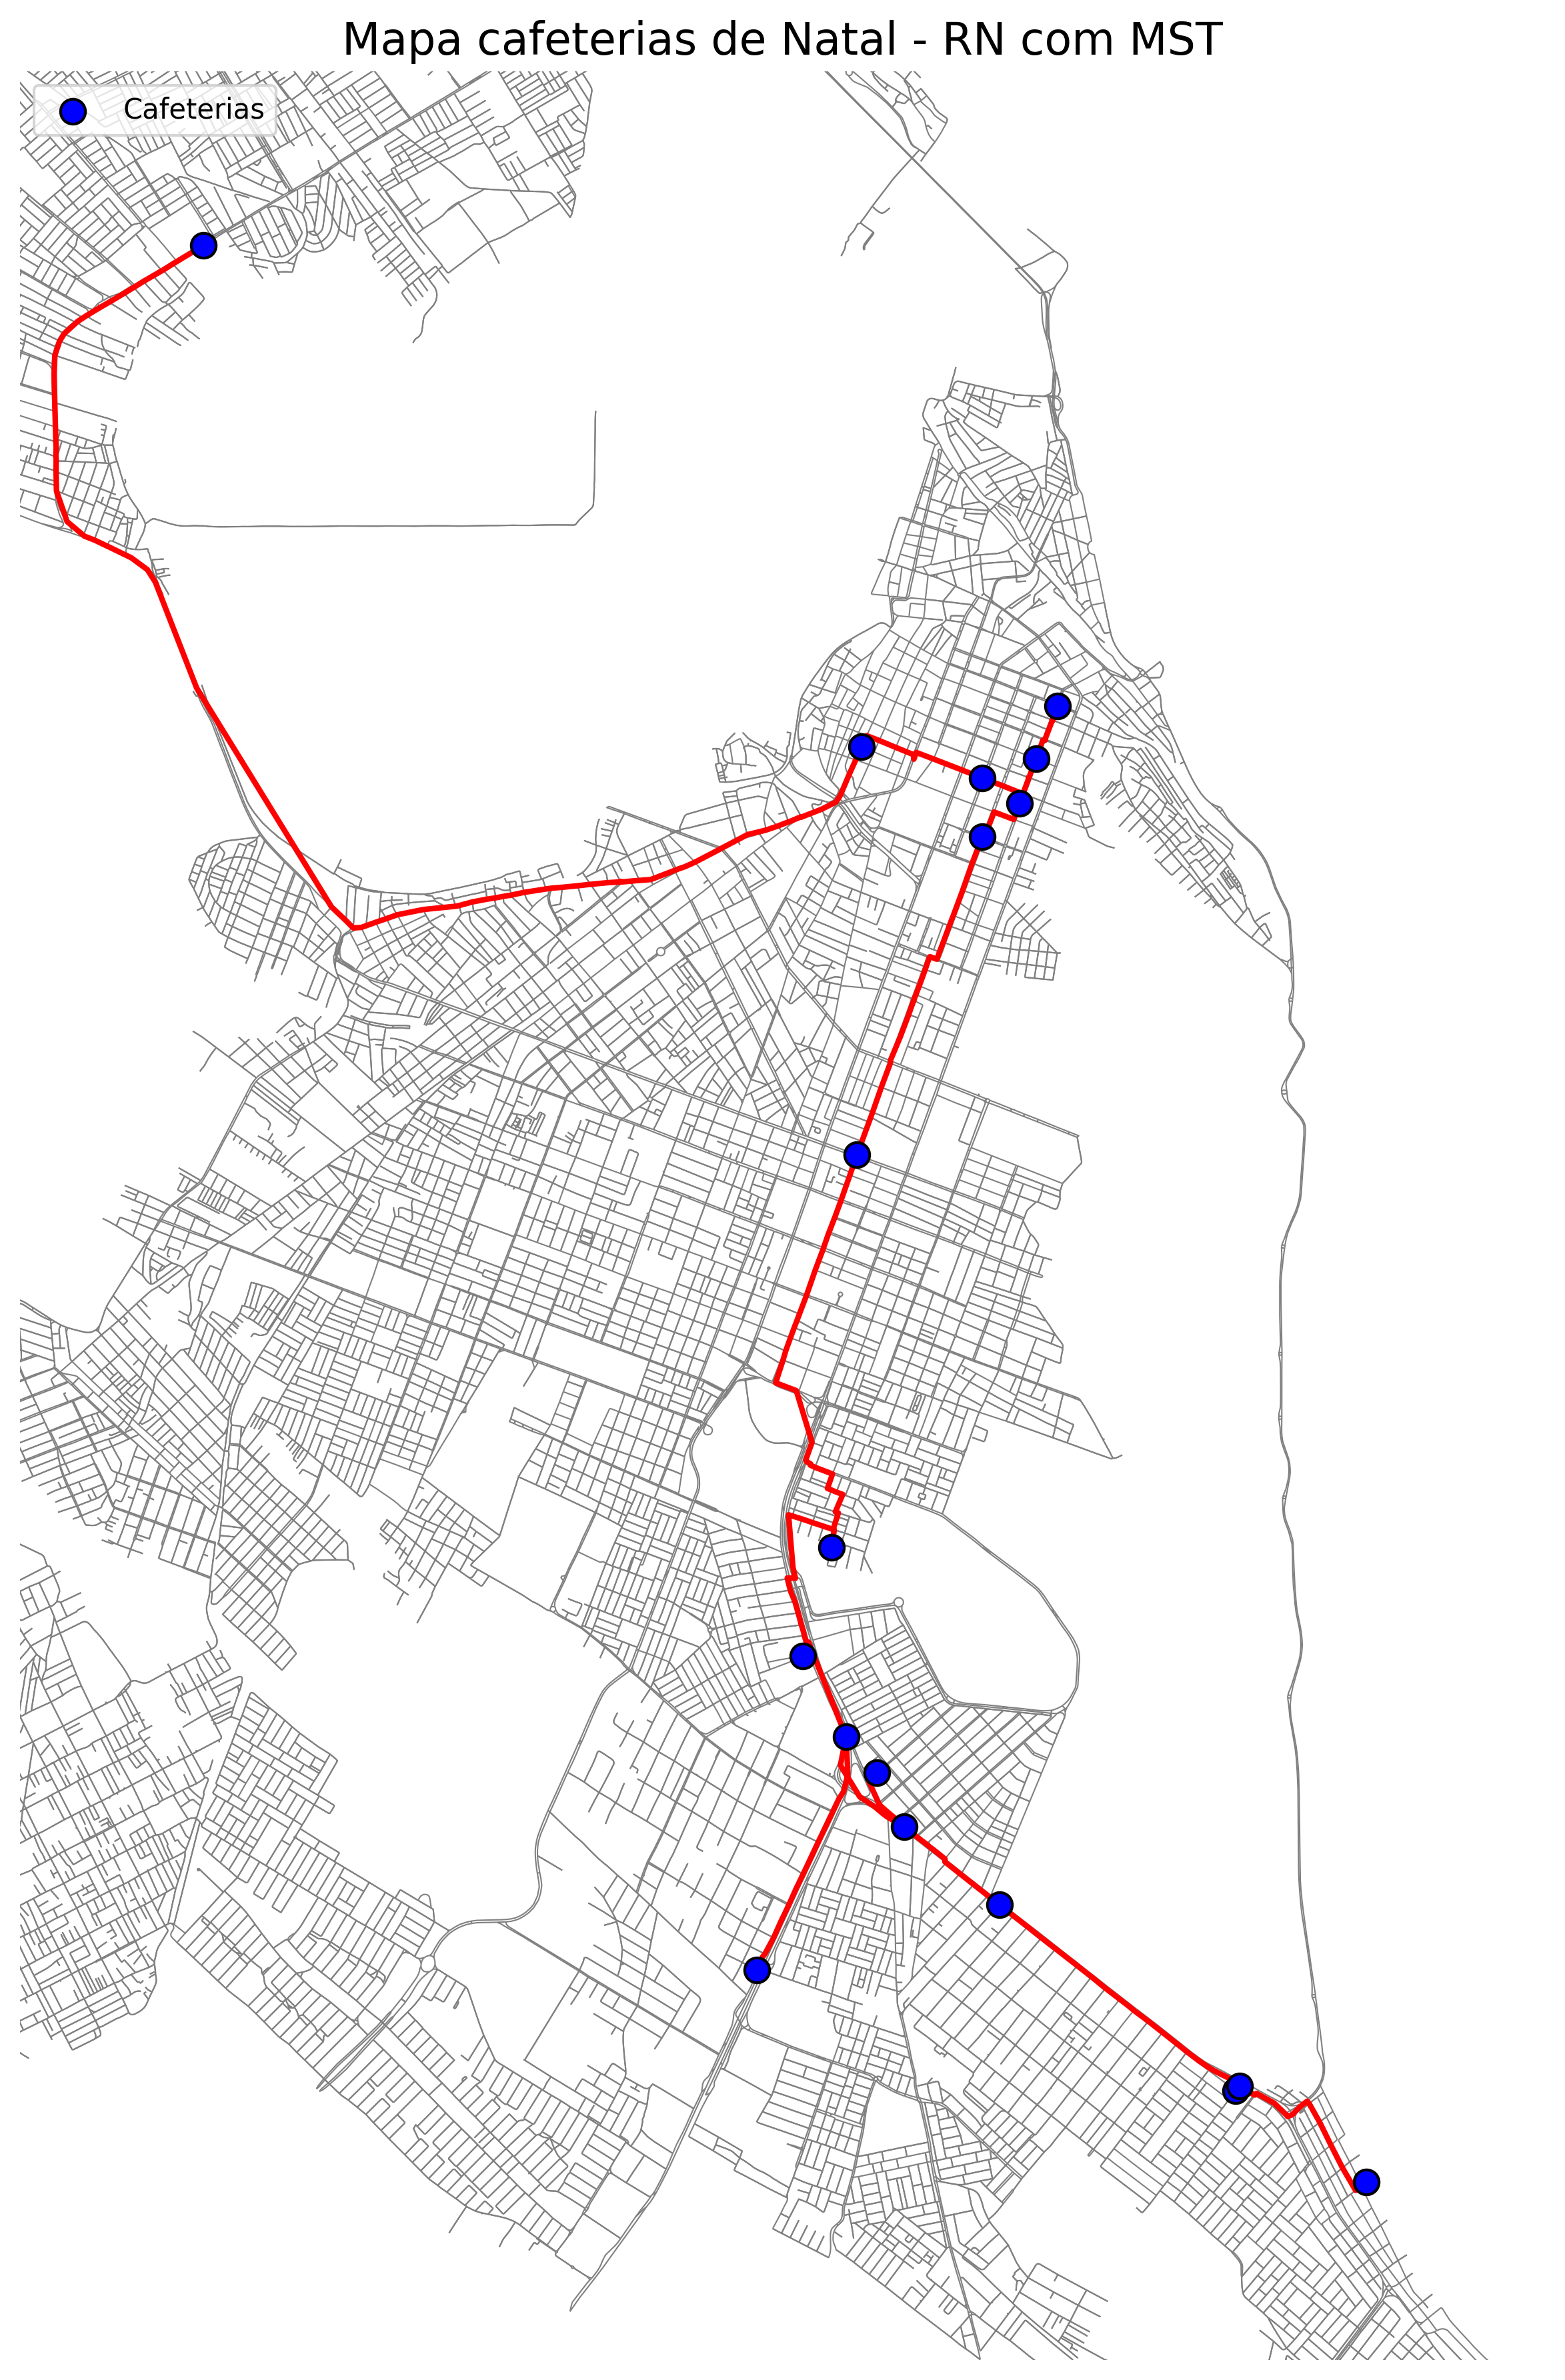

In [49]:
plotar_mst_cafeterias(G_undirected, pois, mst_edges, cafe_nodes)